#Spatial Plotting and Comparison

Compare forecast to historical records

In [1]:
from awrams.visualisation import results
from awrams.utils import extents
from awrams.utils import datetools as dt
from awrams.utils import mapping_types as mt
import numpy as np
from matplotlib import pyplot as plt
import os
from awrams.utils.io import data_mapping as dm
import pandas as pd

In [2]:
ENSEMBLE_BASE_PATH = '/data/cwd_awra_data/awra_test_outputs/SydneyWater/'

allfcast = os.listdir(ENSEMBLE_BASE_PATH)
allfcast = [k for k in allfcast if k.startswith('fcast')]

all_ens = ['e'+str(i).zfill(2) for i in range(1,12)]

from awrams.utils import invert_dict

VARS_OF_INTEREST = ['s0','ss','sm','e0','qtot','etot']
OP_ENS_VAR_MAPPING = dict([(k+'_avg',k) for k in VARS_OF_INTEREST])
ENS_OP_VAR_MAPPING = invert_dict(OP_ENS_VAR_MAPPING)

In [3]:
monthly_awap = results.load_results('/data/cwd_awra_data/awra_test_outputs/Scheduled_v5_awraprod1/processed/values/month')

In [4]:
# Get a single ensemble run to use as a reference for the NSW extent
# This 

ref_ens_res = results.load_results('/data/cwd_awra_data/awra_test_outputs/SydneyWater/fcast20000501/e01/')

In [5]:
# Get soil moisture conversion tables

from awrams.utils.nodegraph import graph
from awrams.models import awral
imap = awral.get_default_mapping()

def get_pct_full(actual,ref_grid):
    return actual/ref_grid

cs = mt.gen_coordset(dt.dates('1 jan 2000'),ref_ens_res.extent) # Arbitrary time coords, only need spatial data

smmap = graph.get_input_tree(['s0max','ssmax','sdmax'],imap.mapping)
smexe = graph.ExecutionGraph(smmap)
smdata = smexe.get_data(cs)
smdata['smmax'] = smdata['s0max'] + smdata['ssmax']

In [6]:
#Workaround for bug in monthly results date handling

p_awap = monthly_awap.variables.dd_avg.reader.sfm.get_coords().time.index

In [7]:
def fix_monthly(in_period):
    '''
    Convert monthly period to end-of-month timestamps
    '''
    return pd.DatetimeIndex([dt.end_of_month(i) for i in in_period])

In [8]:
def get_month_indices(month_str,start_year,end_year):
    midx = dt.monthly_index(month_str,start_year,end_year)
    return [dt.end_of_month(i) for i in midx]

In [9]:
# Set up which forecast we are analysing

START_MONTH = 5
START_YEAR = 2005

curfcast = 'fcast%s%s01' % (str(START_YEAR),str(START_MONTH).zfill(2))
curfcast

'fcast20050501'

In [61]:
# Set year range for calculating historical deciles


mincides = get_month_indices(START_MONTH,1911,2016) # use 'may' or 5

In [110]:
# Get monthly historical reference data

v = 'sm'
ref_v = ENS_OP_VAR_MAPPING[v]

ref_data = []
for i in mincides:
    d = monthly_awap.variables[ref_v].get_data(i,ref_ens_res.extent)
    ref_data.append(d)
    
ref_data = np.array(ref_data)

In [111]:
# Set the historical percentile of interest
# 50 is median.  20 would be represent a 1 in 5 year 'low' event

PERCENTILE_OF_INTEREST = 50 # Median

hist_pct = np.percentile(ref_data,PERCENTILE_OF_INTEREST,axis=0)

In [112]:
eres = results.EnsembleResults(os.path.join(ENSEMBLE_BASE_PATH,'monthly',curfcast))
eresp = eres.results['e01'].variables.sm.reader.sfm.get_coords().time.index


In [113]:
CUR_DATE = eresp[5] # 0 is average over 1 month from forecast start, 5 is average over 6 months
CUR_DATE  

Timestamp('2005-10-31 00:00:00', offset='M')

In [114]:
ens_data = eres.get_ens_results(CUR_DATE,eres.extent,v)

In [115]:
# Convert to array 
ens_array = np.array(list(ens_data.values()))
ens_array = np.ma.MaskedArray(ens_array,True)
ens_array.mask[:] = eres.extent.mask
ens_array.sort(axis=0)

In [116]:
ens_median = np.percentile(ens_array,50,axis=0)

In [117]:
from awrams.utils.processing import deciles

In [118]:
# Get the percentile of ensemble members represented by the historical<percentile> (median by default)
# In other words, what % of ensemble agreement is at or below the historical<percentile>
# Invert these values for % > historical

rel_pct = deciles.get_percentiles_of(hist_pct,ens_array)

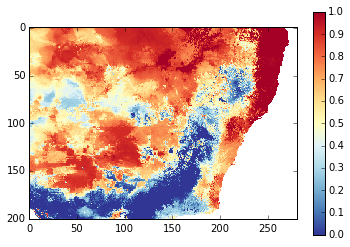

In [119]:
im = plt.imshow(rel_pct,interpolation='None',cmap='RdYlBu_r',vmin = 0.0, vmax = 1.0)
plt.colorbar(im)

In [120]:
# Show a percentile of the ensemble data
# eg '80% of ensemble members are below this value'

ens_pct = np.percentile(ens_array,80,axis=0)

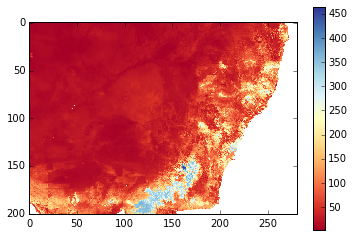

In [121]:
#mm
# ie 80% are below <x> mm

im = plt.imshow(ens_pct,interpolation='None',cmap='RdYlBu')
plt.colorbar(im)

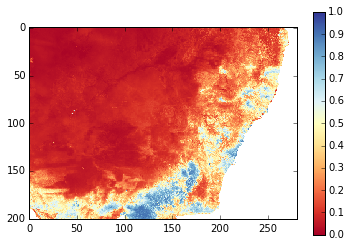

In [122]:
# pct full
# ie 80% are below <proportion> full

if v.startswith('s'):

    ens_pct_pfull = get_pct_full(ens_pct,smdata[v+'max'])

    im = plt.imshow(ens_pct_pfull,vmin=0,vmax=1,interpolation='None',cmap='RdYlBu')
    plt.colorbar(im)
else:
    print("Not a soil moisture variable")

In [123]:
ref_data_s = ref_data.copy()
ref_data_s.sort(axis=0)

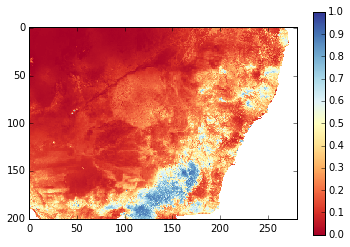

In [124]:
# Actual (AWAP simulation) as percentage full

actual = monthly_awap.variables[ref_v].get_data(CUR_DATE,ref_ens_res.extent)

if v.startswith('s'):

    actual_pfull = get_pct_full(actual,smdata[v+'max'])
    im = plt.imshow(actual_pfull,vmin=0,vmax=1,interpolation='None',cmap='RdYlBu')
    plt.colorbar(im)
else:
    print("Not a soil moisture variable")

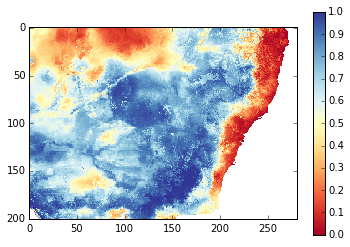

In [125]:
# Actual (AWAP simulation) as percentage of historical record (ie decile value)

actual_rel_pct = deciles.get_percentiles_of(actual,ref_data_s)

im = plt.imshow(actual_rel_pct,vmin=0,vmax=1,interpolation='None',cmap='RdYlBu')
plt.colorbar(im)

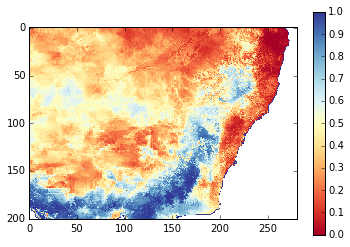

In [126]:
# Ensemble predicted median as percentage of historical record (ie decile value)

#actual = monthly_awap.variables[ref_v].get_data(CUR_DATE,ref_ens_res.extent)

ensmed_rel_pct = deciles.get_percentiles_of(ens_median,ref_data_s)

im = plt.imshow(ensmed_rel_pct,vmin=0,vmax=1,interpolation='None',cmap='RdYlBu')
plt.colorbar(im)

In [127]:
CUR_DATE

Timestamp('2005-10-31 00:00:00', offset='M')